<a href="https://colab.research.google.com/github/kartik727/ml-projects/blob/master/pet_detector/Pet_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q transformers
! pip install -q timm

In [2]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
import numpy as np
from geopy.distance import geodesic
from geopy.point import Point
import folium
from folium.plugins import HeatMap

## Setting up

Setting the API endpoints, API keys, downloading models, etc.

In [3]:
api_url = 'https://maps.googleapis.com/maps/api/streetview'
metadata_url = 'https://maps.googleapis.com/maps/api/streetview/metadata'
api_key = '' # Enter your API key here

In [4]:
model_name = 'facebook/detr-resnet-50'

processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print(f'Using device: {device} - {torch.cuda.get_device_name(0)}')
else:
    print(f'Using device: {device}')

model.to(device)
print('Initialization complete.')

Using device: cuda - Tesla T4
Initialization complete.


## API Handler

This class wraps around the Google Maps API to allow us to easily obtain Street View images.

In [6]:
class APIHandler:
    def __init__(self, api_url:str, metadata_url:str, api_key:str,
            signature:str=None, default_size:tuple[int, int]=(600, 400)
        ):
        self._api_url = api_url
        self._metadata_url = metadata_url
        self._api_key = api_key
        self._signature = signature
        self._default_size = default_size
        self._cache = {}

    def request_image(self, *, location:str=None, pano:str=None, size:tuple[int, int]=None, **kwargs):
        assert (location is None) + (pano is None) == 1, 'Exactly one of `location` or `pano` must be provided'
        size = self._default_size if size is None else size
        params = {
            'size' : f'{size[0]}x{size[1]}',
            'key' : self._api_key }
        if location is None:
            params['pano'] = pano
            cache_key = pano
        else:
            params['location'] = location
            cache_key = pano

        if cache_key in self._cache:
            img = self._cache[cache_key]
        else:
            if self._signature is not None:
                params['signature'] = self._signature
            r = requests.get(self._api_url, params=params|kwargs, stream=True)
            img = Image.open(r.raw)

        return img

    def request_metadata(self, location:str):
        params = {
            'location' : location,
            'key' : self._api_key }
        if self._signature is not None:
            params['signature'] = self._signature
        r = requests.get(self._metadata_url, params=params)
        return r.json()

In [7]:
labels = list(model.config.label2id.keys())
labels.remove('N/A')

print(f'labels: {labels}')

labels: ['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'blender', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'desk', 'dining table', 'dog', 'donut', 'door', 'elephant', 'eye glasses', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'hat', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'mirror', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'plate', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'shoe', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'street sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'window', 'wine glass', 'zebra']


In [8]:
class ObjectLocator:
    def __init__(self, model, processor, api_handler):
        self._model = model
        self._processor = processor
        self._api_handler = api_handler

    def _obj_bbs(self, results:dict)->dict[str, list[tuple[float, list[float]]]]:
        objs = {}
        for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
            label_name = self._model.config.id2label[label.item()]
            if label_name not in objs:
                objs[label_name] = []
            objs[label_name].append((score.item(), box.tolist()))

        return objs

    def _draw_bounding_box(self, im, *, color='red', **bb_data):
        im = im.convert('RGB')
        for label_name, data_list in bb_data.items():
            for score, bb in data_list:
                txt = f'{label_name}: {round(score, 3)}'

                # Draw bounding box
                draw = ImageDraw.Draw(im)
                draw.rectangle(bb, outline=color, width=2)

                # Add text label
                text_width, text_height = draw.textsize(txt)
                draw.rectangle((bb[0], bb[3] - text_height - 4, bb[0] + text_width + 4, bb[3]), fill=color)
                draw.text((bb[0] + 2, bb[3] - text_height - 2), txt, fill='white')#, font=font)

        return im

    def _obj_detection(self, img, threshold=0.9):
        inputs = self._processor(images=img, return_tensors="pt").to(device)
        outputs = self._model(**inputs)

        target_sizes = torch.tensor([img.size[::-1]])
        results = self._processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

        return self._obj_bbs(results)

    def _imshow(self, images, /):
        img = np.concatenate(images, axis=1)
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.imshow(img)
        ax.axis('off')
        fig.show()

    def _dict_add(self, dict_list:list[dict[str, int]]):
        ret = {}
        for d in dict_list:
            for k, v in d.items():
                ret[k] = ret.get(k, []) + v
        return ret

    def _print_results(self, location:str, objects:list[str], result_dict:dict):
        print(f'Location: {location}. Looking for the following objects:')
        print(f'Found the following:')
        for obj in objects:
            print(f'{obj} : {len(result_dict.get(obj, [])):2}')
        print()

    def _location_object_detection(self, pano:str, objects:list[str], *,
            threshold:float=0.9, show_image:bool=False):

        images_with_bb = []
        obj_bbs_requested_list = []
        for heading in [0, 120, 240]:
            image = self._api_handler.request_image(pano=pano, heading=heading, fov=120)
            obj_bbs = self._obj_detection(image, threshold=threshold)
            obj_bbs_requested = {}
            obj_bbs_other = {}

            for k, v in obj_bbs.items():
                if k in objects:
                    obj_bbs_requested[k] = v
                else:
                    obj_bbs_other[k] = v
            obj_bbs_requested_list.append(obj_bbs_requested)

            if show_image:
                image = self._draw_bounding_box(image, color='blue', **obj_bbs_other)
                image = self._draw_bounding_box(image, color='red', **obj_bbs_requested)
                images_with_bb.append(image)

        obj_bbs_requested = self._dict_add(obj_bbs_requested_list)

        if show_image:
            self._imshow(images_with_bb)

        return obj_bbs_requested

    def _get_evenly_spaced_places(self, lat, lon, dist, n):
        center = Point(lat, lon)
        places = []

        # Calculate the angle between each evenly spaced point
        angle = 360.0 / n

        # Generate the evenly spaced places
        for i in range(n):
            # Calculate the latitude and longitude offset for each point
            offset = geodesic(miles=dist).destination(center, angle * i)

            # Append the calculated point to the list of places
            places.append((offset.latitude, offset.longitude))

        return places

    def _get_nearby_points(self, lat, lon, dist, prec):
        all_pts = [(lat, lon)]
        for i, d in enumerate(np.arange(0., dist, prec)):
            n = (i+1)*6
            all_pts.extend(self._get_evenly_spaced_places(lat, lon, d+prec, n))
        return all_pts

    def location_object_detection(self, location:str, objects:list[str], *,
            threshold:float=0.9,
            show_image:bool=True):
        pano = self._api_handler.request_metadata(location)['pano_id']

        return self._location_object_detection(pano, objects, threshold=threshold, show_image=show_image)

    def heatmap(self, location:str, obj:str, *,
            dist:int=5,
            threshold:float=0.9,
            precision:float=0.5
        ):
        pano_ids = dict()
        results = dict()

        location_data = self._api_handler.request_metadata(location)
        lat, lon = location_data['location']['lat'], location_data['location']['lng']
        nearby_latlons = self._get_nearby_points(lat, lon, dist, precision)
        for lat, lon in nearby_latlons:
            loc_data = self._api_handler.request_metadata(f'{lat},{lon}')
            if 'pano_id' in loc_data:
                pano_ids[loc_data['pano_id']] = loc_data

        for pano, data in pano_ids.items():
            try:
                result = self._location_object_detection(pano, [obj], threshold=0.9)
                lat, lon = data['location']['lat'], data['location']['lng']
                results[(lat, lon)] = len(result.get(obj, []))
            except Exception:
                print(f'Warning: Could not add pano: {pano}')
                continue

        return results


In [1]:
def create_heatmap(data):
    # Create a Folium map centered at a specific location
    map_center = list(data.keys())[0]  # Assuming the first key is a valid center
    heatmap_map = folium.Map(location=map_center, zoom_start=12)

    # Convert the data to a format suitable for HeatMap plugin
    heat_data = [(coord[0], coord[1], value) for coord, value in data.items()]

    # Add the heatmap layer to the map
    HeatMap(heat_data).add_to(heatmap_map)

    return heatmap_map

In [10]:
api_handler = APIHandler(api_url, metadata_url, api_key)
object_locator = ObjectLocator(model, processor, api_handler)

In [11]:
location = 'Times Square, New York, NY'
obj_det_objs = ['dog', 'cat']
hm_objs = 'dog', 'cat'

<ipython-input-8-28a3b1c758cb>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(txt)
<ipython-input-8-28a3b1c758cb>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(txt)
<ipython-input-8-28a3b1c758cb>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(txt)
<ipython-input-8-28a3b1c758cb>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(txt)
<ipython-input-8-28a3b1c758cb>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_

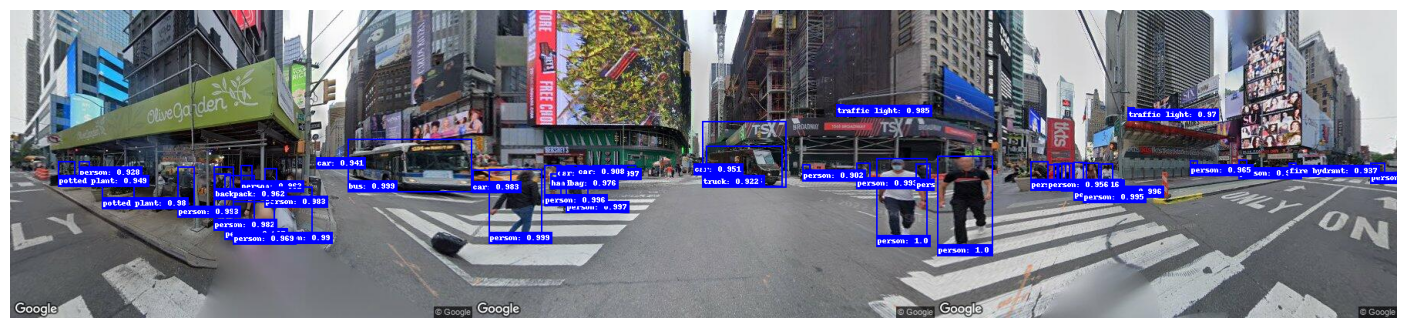

In [12]:
obj_bbs = object_locator.location_object_detection(location, obj_det_objs)

In [13]:
def hm_compare(hm1, hm2):
    hm = {}
    keys = set(hm1.keys()).intersection(set(hm2.keys()))
    for k in keys:
        hm[k] = hm1[k]-hm2[k]
    return hm

In [14]:
dist, prec = 3, 0.25
hm1 = object_locator.heatmap(location, hm_objs[0], dist=dist, precision=prec)
hm2 = object_locator.heatmap(location, hm_objs[1], dist=dist, precision=prec)
create_heatmap(hm_compare(hm1, hm2))